# Test for GPU

In [ ]:
!nvidia-smi

Thu Jun 30 17:47:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Training Data

In [ ]:
!gdown https://drive.google.com/u/2/uc?id=1kmUGf-zq-QgB5LgIWUJPEHCGZZtIZ9V3&export=download
!gdown https://drive.google.com/u/2/uc?id=1rycfwn_kFI837YXnDTSm3LFnhAlYhBw-&export=download
!gdown https://drive.google.com/u/2/uc?id=194H5u7eV19L3ZKM-L9oHxC76Tmz7GopF&export=download

Downloading...
From: https://drive.google.com/u/2/uc?id=1kmUGf-zq-QgB5LgIWUJPEHCGZZtIZ9V3
To: /content/training_spectrogram.npz
100% 3.54G/3.54G [00:39<00:00, 89.5MB/s]
Downloading...
From: https://drive.google.com/u/2/uc?id=1rycfwn_kFI837YXnDTSm3LFnhAlYhBw-
To: /content/validation_spectrogram.npz
100% 442M/442M [00:05<00:00, 82.2MB/s]
Downloading...
From: https://drive.google.com/u/2/uc?id=194H5u7eV19L3ZKM-L9oHxC76Tmz7GopF
To: /content/test_spectrogram.npz
100% 445M/445M [00:04<00:00, 103MB/s]


# Training

This treats the spectrograms of the words like images

In [ ]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import gc

In [ ]:
# clear out any old logs
!rm -rf ./logs/ 

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# List of the words in categorical order
command_words = [
    'forward',
    'backward',
    'left',
    'right',
    '_invalid',
]

In [ ]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('training_spectrogram.npz')
validation_spectrogram = np.load('validation_spectrogram.npz')
test_spectrogram = np.load('test_spectrogram.npz')

(array([44520., 49000., 37520., 42220., 60667.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

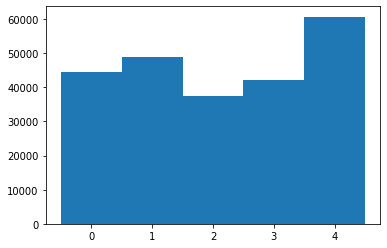

In [ ]:
# plot a distribution of the words
plt.hist(training_spectrogram['Y'], bins=range(0,len(command_words)+1), align='left')

In [ ]:
unique, counts = np.unique(training_spectrogram['Y'], return_counts=True)
print(unique, counts)
dict(zip([command_words[i] for i in unique], counts))

[0 1 2 3 4] [44520 49000 37520 42220 60667]


{'_invalid': 60667,
 'backward': 49000,
 'forward': 44520,
 'left': 37520,
 'right': 42220}

In [ ]:
# extract the data from the files
X_train = training_spectrogram['X']
X_validate = validation_spectrogram['X']
Y_train = tf.one_hot(training_spectrogram['Y'], len(command_words))
Y_validate = tf.one_hot(validation_spectrogram['Y'], len(command_words))

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

train_size = len(X_train)

In [ ]:
# create the datasets for training
batch_size = 32

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    train_size
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0]//10)

In [ ]:
del X_train
del X_validate
del Y_train
del Y_validate

gc.collect()

129

In [ ]:
model = Sequential([
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling3', pool_size=(2,2)),
    Flatten(),
    Dropout(0.1),
    Dense(
        80,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dropout(0.1),
    Dense(
        len(command_words), 
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 49, 21, 4)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 49, 21, 4)         148       
                                                                 
 max_pooling3 (MaxPooling2D)  (None, 24, 10, 4)        0         
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 hidden_layer1 (Dense)       (None, 80)                7

In [ ]:
epochs=3

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

# Train model

In [ ]:
model.fit(
    train_dataset,
    steps_per_epoch=train_size // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=10,
)

Epoch 1/3
14620/14620 [==============================] - 110s 7ms/step - loss: 0.5588 - accuracy: 0.8470 - val_loss: 0.4190 - val_accuracy: 0.9020
Epoch 2/3
14620/14620 [==============================] - 81s 6ms/step - loss: 0.4402 - accuracy: 0.8951 - val_loss: 0.3952 - val_accuracy: 0.9144
Epoch 3/3
14620/14620 [==============================] - 81s 6ms/step - loss: 0.4196 - accuracy: 0.9035 - val_loss: 0.4108 - val_accuracy: 0.9072


In [ ]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model/assets


# Testing the Model

In [ ]:
X_test = test_spectrogram['X']
Y_test = tf.one_hot(test_spectrogram['Y'], len(command_words))

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

In [ ]:
model2 =  keras.models.load_model("trained.model")

In [ ]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

In [ ]:
predictions = model2.predict(X_test, 128)

In [ ]:
import itertools


def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
#     return figure

In [ ]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(Y_test, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)